# Carregando as bibliotecas e os dados

In [7]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from scipy.spatial import distance # type: ignore
from sklearn.cluster import KMeans # type: ignore
import warnings
warnings.filterwarnings("ignore")

# Objetivo: minimizar o número de PAs

# Função para vizinhanças

### Retira o PA menos requisitado

In [8]:
def retira_pa_menos_requisitado(df_pa):
    indice_linha_com_maior_valor = df_pa['carga_disponivel'].idxmax()
    df_pa.drop(indice_linha_com_maior_valor, inplace=True)
    x_novos_pa = list(df_pa['x'])
    y_novos_pa = list(df_pa['y'])
    df_pa = reconstroi_df_pa(x_novos_pa,y_novos_pa)
    return df_pa

### Retira PA mais próximo de outro

In [9]:
def media_dos_pontos(df_pa):
    if len(df_pa) < 2:
        return df_pa  # Não é possível encontrar os dois pontos mais próximos com menos de 2 pontos

    min_dist = float('inf')
    closest_points = None

    for i, row1 in df_pa.iterrows():
        for j, row2 in df_pa.iterrows():
            if i != j:
                dist = np.sqrt((row1['x'] - row2['x'])**2 + (row1['y'] - row2['y'])**2)
                if dist < min_dist:
                    min_dist = dist
                    closest_points = (i, j)

    if closest_points is None:
        return df  # Não foi possível encontrar os dois pontos mais próximos

    i, j = closest_points
    point1 = df_pa.iloc[i]
    point2 = df_pa.iloc[j]
    p_m_x =  ((point1['x'] + point2['x']) / 2)
    p_m_y = ((point1['y'] + point2['y']) / 2)

    condicao = ((df_pa['PA_id'] == (point1['PA_id'])) | (df_pa['PA_id'] == (point2['PA_id'])))
    df_pa = df_pa.drop(df_pa[condicao].index) # remove PAs mais próximas

    x_novos_pa = list(df_pa['x'])
    x_novos_pa.append(p_m_x)
    y_novos_pa = list(df_pa['y'])
    y_novos_pa.append(p_m_y)

    df_pa = reconstroi_df_pa(x_novos_pa,y_novos_pa)

    return df_pa

### Retira os dois pontos mais próximos entre si e substitui pela média

In [10]:
def retira_pa_proximo(df_pa):
    if len(df_pa) < 2:
        return df_pa  # Não é possível encontrar os dois pontos mais próximos com menos de 2 pontos

    min_dist = float('inf')
    closest_points = None

    for i, row1 in df_pa.iterrows():
        for j, row2 in df_pa.iterrows():
            if i != j:
                dist = np.sqrt((row1['x'] - row2['x'])**2 + (row1['y'] - row2['y'])**2)
                if dist < min_dist:
                    min_dist = dist
                    closest_points = (i, j)

    if closest_points is None:
        return df  # Não foi possível encontrar os dois pontos mais próximos

    i, j = closest_points
    point = df_pa.iloc[i]

    condicao = (df_pa['PA_id'] == (point['PA_id']))
    df_pa = df_pa.drop(df_pa[condicao].index) # remove PA mais próximas

    x_novos_pa = list(df_pa['x'])
    y_novos_pa = list(df_pa['y'])

    df_pa = reconstroi_df_pa(x_novos_pa,y_novos_pa)

    return df_pa

# Funções

In [11]:
def calcular_distancia(cliente, PAs):
    distancias = [distance.euclidean(cliente, PA) for PA in PAs]
    return distancias

def get_pa_prox(df_clients, df_pa):
    distancias = []
    for index, row in df_clients[['x','y']].iterrows():
        distancias_cliente = calcular_distancia(row, df_pa[['x','y']].values)
        #pontos_de_pa = df_pa[['x','y']].index[np.argsort(distancias_cliente)].tolist() 
        pontos_de_pa = df_pa[['x','y']].index.tolist()
        
        pontos_proximos = {pontos_de_pa[i]: distancias_cliente[i] for i in range(len(pontos_de_pa))}
        pontos_proximos = {chave: valor for chave, valor in pontos_proximos.items() if valor < 70} # pega os pas com distancia menor que 70
        pontos_proximos = dict(sorted(pontos_proximos.items(), key=lambda item: item[1]))
        pontos_proximos = list(pontos_proximos.keys())
        
        distancias.append(pontos_proximos)
        #distancias.append({'client_id': index, 'pontos_proximos': pontos_proximos})
    
    df_pa_prox = df_clients
    df_pa_prox['pontos_proximos'] = distancias
    return df_pa_prox

def verificacao_de_atendimento_de_demanda(numero_de_clientes,df_pa_prox):
    #verificando se todo cliente tem uma PA por perto
    vazias = df_pa_prox['pontos_proximos'].apply(lambda x: len(x) == 0)
    num_nao_atendidos = vazias.sum() # numero de clientes nao atendidos
    return 1 - num_nao_atendidos/numero_de_clientes

def reconstroi_df_pa(x,y): #recebe uma lista x e uma lista y
    df_pa = pd.DataFrame({'x':x,'y':y})
    df_pa['carga_disponivel'] =  [54]*len(df_pa)
    df_pa['PA_id'] = df_pa.index
    df_pa['x'] = df_pa['x'].apply(lambda x: round(x / 5) * 5)
    df_pa['y'] = df_pa['y'].apply(lambda y: round(y / 5) * 5)
    return df_pa

def shake(df_pa, k):    
    if k == 1:        
        df_pa = retira_pa_menos_requisitado(df_pa)
    elif k == 2:                
        df_pa = retira_pa_proximo(df_pa)
    elif k == 3:    
        df_pa = media_dos_pontos(df_pa)
    return df_pa

def neighborhoodChange(df_pa):
    n_clusters = 25
    
    # Aplicar o algoritmo K-Means novamente para redefinir vizinhanca
    kmeans = KMeans(n_clusters=n_clusters)
    df_clients['cluster'] = kmeans.fit_predict(df_clients[['x', 'y']])
    df_pa = pd.DataFrame(kmeans.cluster_centers_, columns=['x','y'])
    df_pa['carga_disponivel'] =  [54]*len(df_pa)
    df_pa['PA_id'] = df_pa.index
    df_pa['x'] = df_pa['x'].apply(lambda x: round(x / 5) * 5)
    df_pa['y'] = df_pa['y'].apply(lambda y: round(y / 5) * 5)
    return df_pa

# Dados dos clientes

KeyError: 'x'

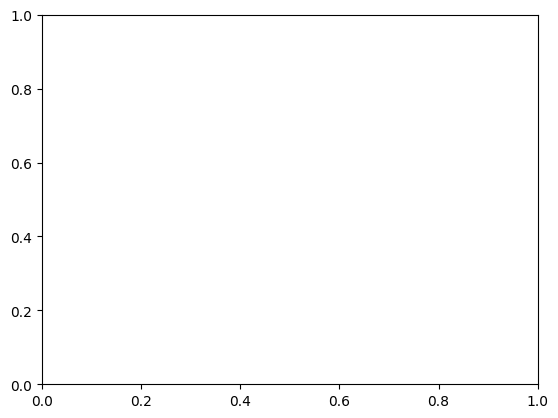

In [16]:
df_clients = pd.read_csv('data/clientes.csv')
df_clients['client_id'] = df_clients.index
df_clients.plot(x='a', y='y', kind='scatter', xlim=(-50, 450), ylim=(-50, 450))
plt.show()

# Solução Inicial: K-MeansMEANS

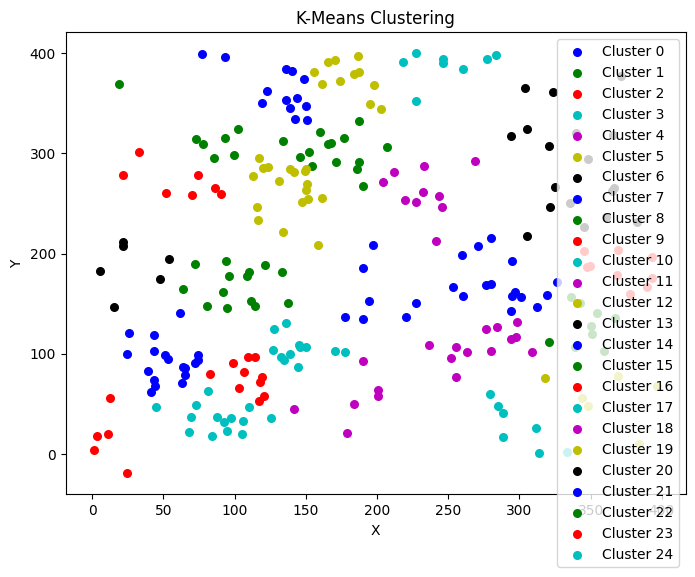

In [ ]:
# Número de clusters que você deseja criar
n_clusters = 25

# Aplicar o algoritmo K-Means
kmeans = KMeans(n_clusters=n_clusters)
df_clients['cluster'] = kmeans.fit_predict(df_clients[['x', 'y']])

df_pa = pd.DataFrame(kmeans.cluster_centers_, columns=['x','y'])
df_pa['carga_disponivel'] =  [54]*len(df_pa)
df_pa['PA_id'] = df_pa.index
df_pa['x'] = df_pa['x'].apply(lambda x: round(x / 5) * 5)
df_pa['y'] = df_pa['y'].apply(lambda y: round(y / 5) * 5)
df_pa.head()

# Plote os pontos coloridos pelos clusters
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k','b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k','b', 'g', 'r', 'c', 'm', 'y', 'k']
for cluster_num in range(n_clusters):
    cluster_points = df_clients[df_clients['cluster'] == cluster_num]
    plt.scatter(cluster_points['x'], cluster_points['y'], s=30, c=colors[cluster_num], label=f'Cluster {cluster_num}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('K-Means Clustering')
plt.legend()
plt.show()

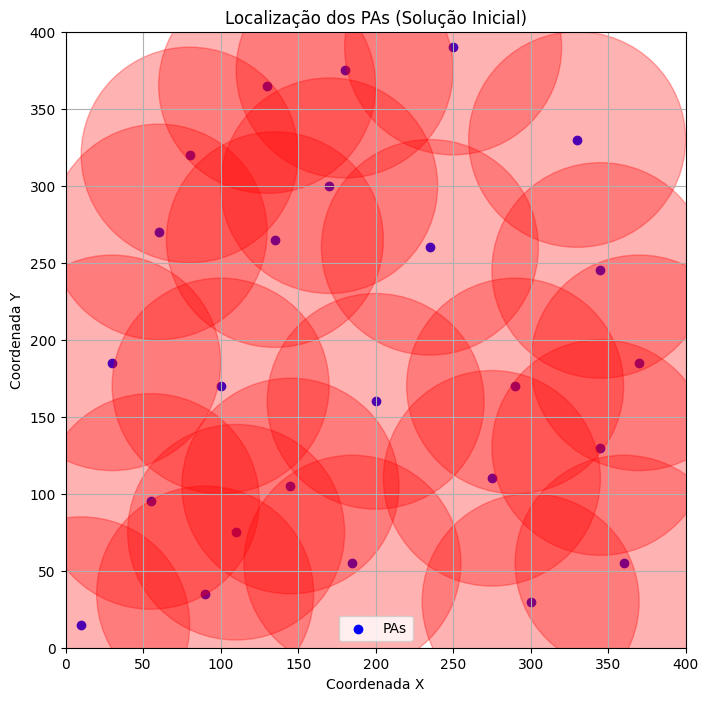

In [ ]:
# Defina o tamanho do espaço cartesiano
tamanho_espaco = 400

# Defina o raio de alcance dos PAs
raio_alcance = 70

# localização de cada PA com seu raio de alcance
plt.figure(figsize=(8, 8))
plt.scatter(df_pa['x'], df_pa['y'], marker='o', color='blue', label='PAs')
for i, row in df_pa.iterrows():
    circle = plt.Circle((row['x'], row['y']), raio_alcance, color='red', alpha=0.3)
    plt.gca().add_patch(circle)

plt.xlim(0, tamanho_espaco)
plt.ylim(0, tamanho_espaco)
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Localização dos PAs (Solução Inicial)')
plt.grid(True)
plt.legend()
plt.show()

# Minimizar Pontos de Acesso

In [ ]:
df_pa_prox = get_pa_prox(df_clients, df_pa)
verificacao_de_atendimento_de_demanda(len(df_clients), df_pa_prox) # se 1.0, 100% dos clientes foram atendidos

0.99609375

In [ ]:
tentativas = 0
menores_quantidades_de_pa = []
perc_clientes_atendidos= []
clientes_atendidos_todas_tentativas = []
quantidade_PAs_todas_tentativas = []
menores_dfs_pas = []
menor_df_pa_prox_todas = []
while(tentativas<=):
    print(f'>tentativa {tentativas}')

    
    max_iter = 50
    k_max = 3
    k=1
    iter = 1
    df_pa_prox = get_pa_prox(df_clients, df_pa)
    menor_df_pa = df_pa
    menor_df_pa_prox = get_pa_prox(df_clients, df_pa)
    clientes_atendidos_tentativa=[verificacao_de_atendimento_de_demanda(len(df_clients), df_pa_prox)]
    quantidade_PAs_tentativa = [len(df_pa)]
    
    while(iter<max_iter):
        while(k<=k_max):
            
            df_pa = shake(df_pa,k)
            df_pa_prox = get_pa_prox(df_clients, df_pa)
            #desconta a carga de demanda dos clientes em seus respectivos PAs
            for i in range(len(df_pa_prox)):
                try: #verifica se ha pa perto do cliente
                    PA_client = df_pa_prox.iat[i,4]
                    df_pa.loc[df_pa['PA_id'] == PA_client, 'carga_disponivel'] -= df_pa_prox.iat[i,2] #desconta a demanda que o cliente usa do PA
                except: continue
            quantidade_PAs_tentativa.append(len(df_pa))
            clientes_atendidos_tentativa.append([verificacao_de_atendimento_de_demanda(len(df_clients), df_pa_prox)])
            if ((df_pa['carga_disponivel'] < 0).all()): # algum pa foi sobrecarregado
                df_pa = neighborhoodChange(df_pa)
    
            if(verificacao_de_atendimento_de_demanda(len(df_clients), df_pa_prox) < 0.95): #verifica se 95% dos clientes estao sendo atendidos
                df_pa = neighborhoodChange(df_pa)
            
            if len(df_pa)<len(menor_df_pa):
                menor_df_pa = df_pa
                menor_df_pa_prox = get_pa_prox(df_clients, df_pa)
            k+=1
        k=1 # volta ao primeiro shake
        iter+=1
        if iter % 10 == 0:  # Verifica se i é divisível por 10
            print(f">>>>iteracao {iter}")
    menores_dfs_pas.append(menor_df_pa)
    menor_perc = verificacao_de_atendimento_de_demanda(len(df_clients), menor_df_pa_prox)    
    tentativas+=1
    menores_quantidades_de_pa.append(len(menor_df_pa))
    menor_df_pa_prox_todas.append(menor_df_pa_prox)
    perc_clientes_atendidos.append(menor_perc)
    clientes_atendidos_todas_tentativas.append(clientes_atendidos_tentativa)
    quantidade_PAs_todas_tentativas.append(quantidade_PAs_tentativa)  

>tentativa 0
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iteracao 40
>>>>iteracao 50
>tentativa 1
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iteracao 40
>>>>iteracao 50
>tentativa 2
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iteracao 40
>>>>iteracao 50
>tentativa 3
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iteracao 40
>>>>iteracao 50
>tentativa 4
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iteracao 40
>>>>iteracao 50
>tentativa 5
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iteracao 40
>>>>iteracao 50
>tentativa 6
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iteracao 40
>>>>iteracao 50
>tentativa 7
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iteracao 40
>>>>iteracao 50
>tentativa 8
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iteracao 40
>>>>iteracao 50
>tentativa 9
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iteracao 40
>>>>iteracao 50
>tentativa 10
>>>>iteracao 10
>>>>iteracao 20
>>>>iteracao 30
>>>>iter

In [ ]:
print(menores_quantidades_de_pa)
print(perc_clientes_atendidos)

[17, 16, 16, 15, 15, 17, 15, 16, 16, 14, 14]
[0.98828125, 0.98828125, 0.96875, 1.0, 1.0, 0.98828125, 0.96875, 1.0, 0.98828125, 0.99609375, 0.95703125]


In [ ]:
# podemos ver acima que o melhor resultado foi o penultimo pois teve menos PAs e teve a melhor cobertura

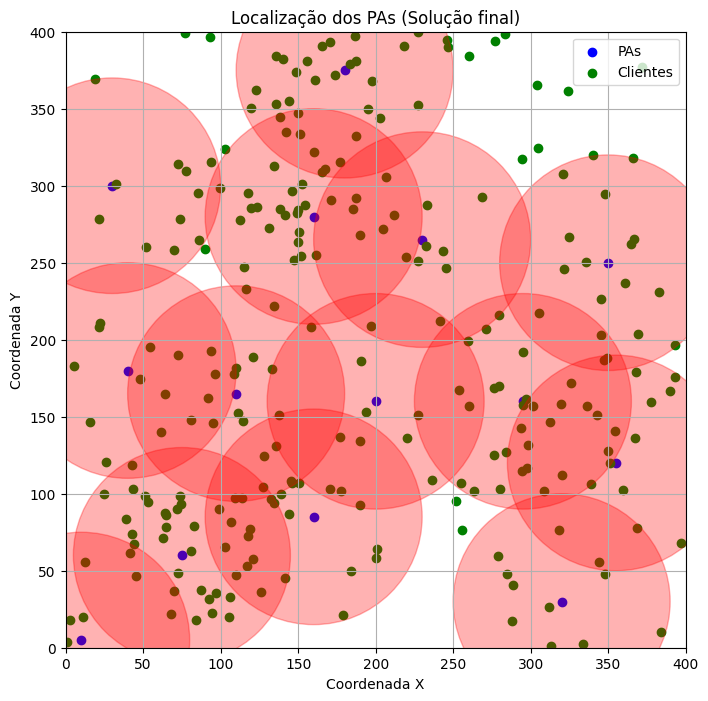

In [ ]:
# localização de cada PA com seu raio de alcance
plt.figure(figsize=(8, 8))
plt.scatter(menores_dfs_pas[-2]['x'], menores_dfs_pas[-2]['y'], marker='o', color='blue', label='PAs')
plt.scatter(df_clients['x'], df_clients['y'], marker='o', color='green', label='Clientes')

for i, row in menores_dfs_pas[-2].iterrows():
    circle = plt.Circle((row['x'], row['y']), raio_alcance, color='red', alpha=0.3)
    plt.gca().add_patch(circle)

plt.xlim(0, tamanho_espaco)
plt.ylim(0, tamanho_espaco)
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Localização dos PAs (Solução final)')
plt.grid(True)
plt.legend()
plt.show()

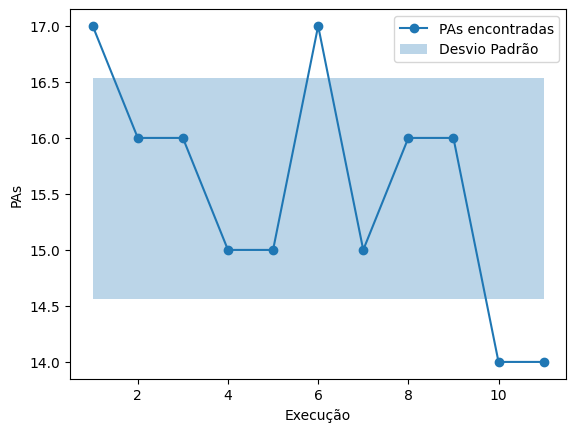

In [ ]:
iteracoes = list(range(1, len(menores_quantidades_de_pa) + 1))

# Calcula a média e o desvio padrão
media = np.mean(menores_quantidades_de_pa)
desvio_padrao = np.std(menores_quantidades_de_pa)

# Plota os valores em um gráfico de linhas
plt.plot(iteracoes, menores_quantidades_de_pa, marker='o', linestyle='-', label='PAs encontradas')

# Preenche a área correspondente ao desvio padrão
plt.fill_between(iteracoes, media - desvio_padrao, media + desvio_padrao, alpha=0.3, label='Desvio Padrão')

# Define rótulos para os eixos x e y
plt.xlabel('Execução')
plt.ylabel('PAs')

# Adiciona uma legenda
plt.legend()

# Exibe o gráfico
plt.show()


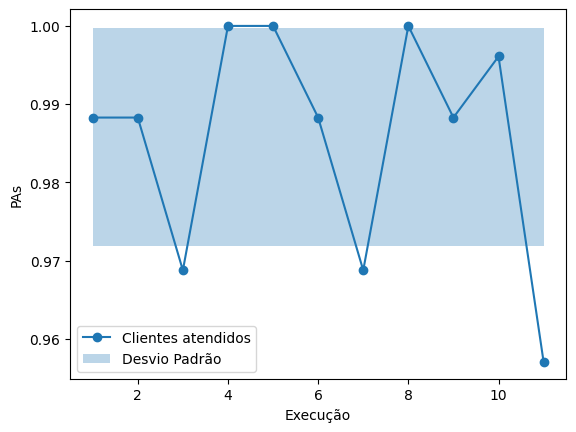

In [ ]:
iteracoes = list(range(1, len(perc_clientes_atendidos) + 1))

# Calcula a média e o desvio padrão
media = np.mean(perc_clientes_atendidos)
desvio_padrao = np.std(perc_clientes_atendidos)

# Plota os valores em um gráfico de linhas
plt.plot(iteracoes, perc_clientes_atendidos, marker='o', linestyle='-', label='Clientes atendidos')

# Preenche a área correspondente ao desvio padrão
plt.fill_between(iteracoes, media - desvio_padrao, media + desvio_padrao, alpha=0.3, label='Desvio Padrão')

# Define rótulos para os eixos x e y
plt.xlabel('Execução')
plt.ylabel('PAs')

# Adiciona uma legenda
plt.legend()

# Exibe o gráfico
plt.show()
